# Capstone Project- Time Series Modeling Workbook
Cary Mosley, May 2020

## Import Libraries

In [1]:
import pandas as pd
import calendar, time
import datetime as dt
from datetime import date
from pandas.tseries.offsets import DateOffset
import numpy as np
import string, re 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error



import warnings
warnings.filterwarnings("once")

## Outline
* First I will check for stationarity/unit roots using the Dickey-Fuller and if I find the time series are not stationary I will work with the data to arrive at stationarity.
* I will construct ARIMAX models for both SPY and VIX seperately using senitment indicators and the NY Times sentiment analysis seperately
* I will work with my sentiment indicators to feature engineer and then build another set of ARIMAX models using this data
* I will create a VAR model using SPY and VIX together

# Stationarity

The first thing I'm going to do is check for unit roots on SPY and VIX using a Dickey Fuller test.

In [61]:

def DickeyFullerTest(time_series, alpha = .05):
    '''This function takes in a time series and then outputs and formats the results of
    a Dickey-Fuller test You can also optionally send in a specific p value.
    '''
    #initialize test
    DFTest = adfuller(time_series)
    
    #results
    results = pd.Series(DFTest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    if results[1] > alpha:
        print('We fail to reject the null hypothesis that there is a unit root as our p-value of'
              , round(results[1],3), 'is greater than our alpha of', alpha,'\n')
    else:
        print('Our p-value of', round(results[1],3), 'is less than our alpha of', alpha,
              'so we reject the null hypothesis that there is a unit root. The data is stationary.\n')
    print ('Dickey-Fuller test: \n')
    print(results)

In [53]:
# Read in the SPY and VIX data
spy_df=pd.read_pickle('Data/spy_df')
vix_df=pd.read_pickle('Data/vix_df')

In [54]:
#Dropping the ticker column
spy_df = spy_df['Adj Close'].to_frame()
vix_df = vix_df['Adj Close'].to_frame()

Now I will run the Dickey Fuller tests


In [55]:
spy_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 723 entries, 2006-06-29 to 2020-04-30
Freq: W-THU
Data columns (total 1 columns):
Adj Close    723 non-null float64
dtypes: float64(1)
memory usage: 11.3 KB


In [62]:
#Set alpha
alpha = .05
DickeyFullerTest(spy_df['Adj Close'],alpha)

We fail to reject the null hypothesis that there is a unit root as our p-value of 0.974 is greater than our alpha of 0.05 

Dickey-Fuller test: 

Test Statistic                   0.223900
p-value                          0.973571
#Lags Used                       9.000000
Number of Observations Used    713.000000
dtype: float64


In [63]:
DickeyFullerTest(vix_df['Adj Close'],alpha)

Our p-value of 0.031 is less than our alpha of 0.05 so we reject the null hypothesi that there is a unit root. The data is stationary.

Dickey-Fuller test: 

Test Statistic                  -3.042269
p-value                          0.031131
#Lags Used                      11.000000
Number of Observations Used    711.000000
dtype: float64


The SPY data is not stationary while the VIX data already is. I'll difference the SPY data and then perform the Dickey Fuller test again.

In [65]:
spy_diff = spy_df.diff().dropna()

In [67]:
DickeyFullerTest(spy_diff['Adj Close'],alpha)

Our p-value of 0.0 is less than our alpha of 0.05 so we reject the null hypothesi that there is a unit root. The data is stationary.

Dickey-Fuller test: 

Test Statistic                -9.722162e+00
p-value                        9.480394e-17
#Lags Used                     8.000000e+00
Number of Observations Used    7.130000e+02
dtype: float64


Text(0.5, 1.0, 'Differenced SPY close over time')

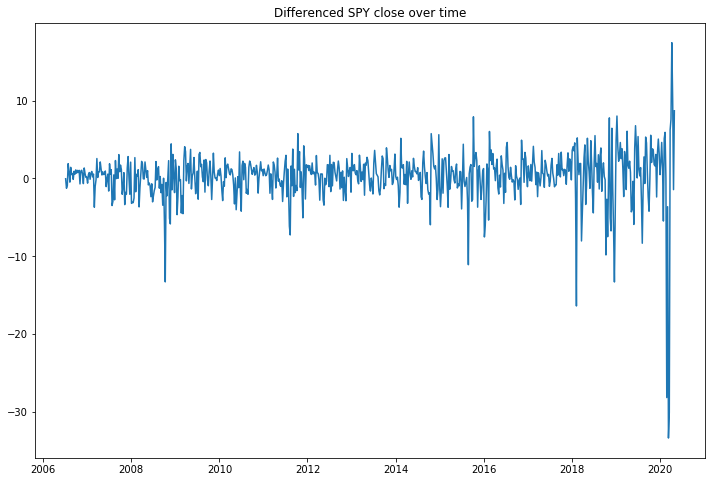

In [70]:
plt.figure(figsize=(12,8))
plt.plot(spy_diff)
plt.title('Differenced SPY close over time')

In [82]:
#Writing the differenced SPY to a pickle
spy_diff.to_pickle('Data/spy_diff')

Now that we have confirmed both our time series are stationary its time to examine the ACF and PACF plots so that we can build our baseline models.

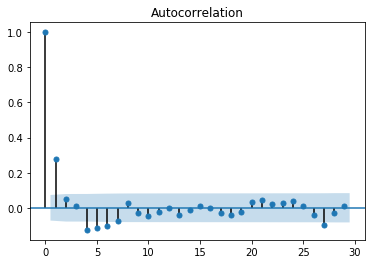

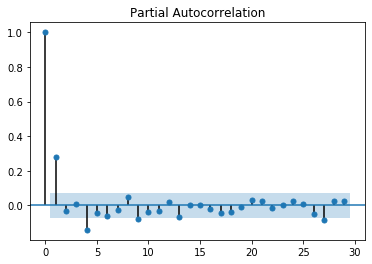

In [81]:
alpha=.05
plot_acf(spy_diff['Adj Close'], alpha=alpha);
plot_pacf(spy_diff['Adj Close'], alpha=alpha);

The autocorrelation plot tells us whether we need to add MA terms. It is clear that the first lag is significant and then possible a few later lags might be. The PACF plot shows us also that the 1st and maybe 4th lag are going to be useful to include as the AR term. For this first model I'll make sure to use a (1,1,1) and will try some other combinations as well. These plots also look typical for a random walk time series.

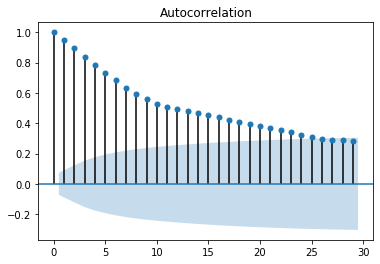

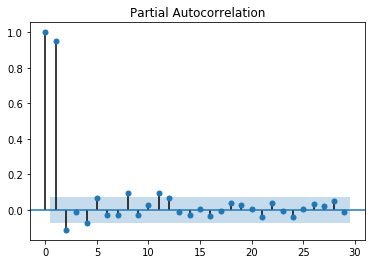

In [83]:
alpha=.05
plot_acf(vix_df['Adj Close'], alpha=alpha);
plot_pacf(vix_df['Adj Close'], alpha=alpha);

We can see from the ACF plot that there are a number of strongly positively correlated lags we can use for the moving average model. This is somewhat expected as there is a tendency for VIX to be sticky for a period of time although it does tend to mean revert to a white noise series. The PACF shows us that only the first lag is strongly correlated. Thus a (1,0,n) model is likely to be decent with n potentially being a number of variables.

Now that we have looked through these I will build some baseline ARIMA models and then will incorporate the sentiment data.

# Modeling
This next section will begin with building and evaluatiing ARIMA models for SPY and VIX before expanding to include the exogenous variables.
## ARIMA Models


In [145]:
def ARIMA_models(time_series,AR_terms,MA_terms):
    '''This function takes in a timeseries and a set of AR and MA terms to try. The time series
    that it takes in needs to be already stationary. The function then returns a data frame
    of the model results'''
    #I'm going to break the time series into a train and test set using the earlier data as the train
    time_train = time_series[:'2017-12']
    time_test = time_series['2018-01':]
    
    #Create results dataframe
    results = pd.DataFrame(columns=['Order', 'AIC', 'BIC', 'Test RMSE'])
    
    #ignore orders that do not converge or cause other erros
    for p in AR_terms:
        for q in MA_terms:
            try:
                order = (p,0,q)
                time_series_model = ARIMA(time_train,order=order)
                time_series_fitted = time_series_model.fit()
                forecast, se, conf = time_series_fitted.forecast(len(time_test),alpha=.05)
                aic = round(time_series_fitted.aic,3)
                bic = round(time_series_fitted.bic,3)
                test_rmse = np.sqrt(mean_squared_error(time_test.values,forecast))
                results = results.append({'Order': order, 'AIC' : aic,
                           'BIC': bic,'Test RMSE': round(test_rmse,3)},ignore_index=True)
            except:
                print('Order',order,'caused an error.')
                continue
    return results
    

In [146]:
AR_terms = [1,2]
MA_terms = [1,2]
ARIMA_models(spy_diff,AR_terms,MA_terms)

,Order,AIC,BIC,Test RMSE
0,"(1, 0, 1)",2598.656,2616.244,6.690
1,"(1, 0, 2)",2600.653,2622.637,6.690
2,"(2, 0, 1)",2600.643,2622.628,6.690
3,"(2, 0, 2)",2602.645,2629.027,6.689


These models look almost identical so we will choose the model we expected from our ACF and PACF plots of (1,1,1)

In [147]:
AR_terms = [1,2,3,4,5]
MA_terms = [1,2,3,4,5]
ARIMA_models(vix_df,AR_terms,MA_terms)

/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:668: RuntimeWarning: invalid value encountered in true_divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/Users/carymosley/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
 

Order (5, 0, 5) caused an error.


,Order,AIC,BIC,Test RMSE
0,"(1, 0, 1)",2830.392,2847.986,10.099
1,"(1, 0, 2)",2832.303,2854.296,10.097
2,"(1, 0, 3)",2832.087,2858.479,10.092
3,"(1, 0, 4)",2833.807,2864.597,10.093
4,"(1, 0, 5)",2835.561,2870.750,10.092
5,"(2, 0, 1)",2832.229,2854.222,10.097
6,"(2, 0, 2)",2834.049,2860.440,10.101
7,"(2, 0, 3)",2833.800,2864.590,10.093
8,"(2, 0, 4)",2835.762,2870.950,10.093
9,"(2, 0, 5)",2837.514,2877.102,10.092


For the VIX data we can see that the (1,0,1) model performs the best although soe of the higher order lags also perform very similarly. Now I will add the exogenous variables.

## Adding Sentiment Indicators as an Exogenous variable